In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms, rdmolops
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
from tensorflow.contrib.distributions import Normal
np.set_printoptions(precision=4)


In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [3]:
def featurize_mols(mol_files, max_n_atoms, n_bonds=5, get_angle=True):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            elif "mol" in mol_file:
                mol = Chem.MolFromMol2File(mol_file)
            else:
                get_angle = False
                mol = Chem.MolFromSmiles(mol_file)
            if mol is None:
                features.append(None)
                continue
            
            if get_angle:
                mol_xyz = get_xyz_from_mol(mol)
                centroid = compute_centroid(mol_xyz)
                mol_xyz -= centroid
                temp = np.zeros((max_n_atoms, 3))
                try:
                    temp[:mol_xyz.shape[0]] = mol_xyz
                except:
                    features.append(None)
                    continue
                mol_xyz = temp
                c = mol.GetConformer(0)

            else:
                mol_xyz = np.zeros((max_n_atoms,3))
                AllChem.EmbedMultipleConfs(mol, 1)
                c = mol.GetConformer(0)
                for aid in range(mol.GetNumAtoms()):
                    pos = c.GetAtomPosition(aid)
                    mol_xyz[aid] = [pos.x, pos.y, pos.z]

            torsions = []
            torsion_tuples = []

            torsion_matrix = np.zeros((n_bonds,1))
            torsion_indices = np.zeros((n_bonds, max_n_atoms, 4)).astype(np.uint8)
            subgraphs = np.zeros((n_bonds, max_n_atoms, max_n_atoms)).astype(np.uint8)
            atom_index_of_bond = np.zeros((n_bonds, max_n_atoms)).astype(np.uint8)
            rot_vectors = np.zeros((n_bonds, 3))
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            idx = 0
            for bond in mol.GetBonds():
                if bond.IsInRing(): 
                    continue
                def calc_torsions(atom_i, atom_j, bond_idx):        
                    exist_dihed = False
                    for neighbor_j in atom_j.GetNeighbors():
                        if neighbor_j.GetIdx() == atom_i.GetIdx():
                            continue

                        dihed_idx = 0
                        for neighbor_i in atom_i.GetNeighbors():
                            if neighbor_i.GetIdx() == atom_j.GetIdx():
                                continue

                            exist_dihed=True
                            torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                            if get_angle:
                                torsion_matrix[bond_idx][dihed_idx] = rdMolTransforms.GetDihedralRad(c, *torsion_tuple)
                            torsion_indices[bond_idx][torsion_tuple[0]][dihed_idx*4] = 1
                            torsion_indices[bond_idx][torsion_tuple[1]][dihed_idx*4+1] = 1
                            torsion_indices[bond_idx][torsion_tuple[2]][dihed_idx*4+2] = 1
                            torsion_indices[bond_idx][torsion_tuple[3]][dihed_idx*4+3] = 1
                            
                            broken_mol = rdmolops.FragmentOnBonds(mol, [bond.GetIdx()], addDummies=False)
                            molfrags = rdmolops.GetMolFrags(broken_mol)
                            if bond.GetEndAtom().GetIdx() in molfrags[0]:
                                atoms_to_rotate = molfrags[0]
                            else:
                                atoms_to_rotate = molfrags[1]


                            subgraph = np.zeros((max_n_atoms, max_n_atoms)).astype(np.uint8)
                            for atom_idx in atoms_to_rotate:
                                subgraph[atom_idx,atom_idx] = 1
                            subgraphs[bond_idx, :, :] = subgraph
                            atom_index_of_bond[bond_idx, atom_j.GetIdx()] = 1
                            
                            pos_i = c.GetAtomPosition(atom_i.GetIdx())
                            pos_j = c.GetAtomPosition(atom_j.GetIdx())
                            pt_i = np.array([pos_i.x, pos_i.y, pos_i.z])
                            pt_j = np.array([pos_j.x, pos_j.y, pos_j.z])
                            vec = pt_j - pt_i
                            vec = vec / np.linalg.norm(vec)
                            rot_vectors[bond_idx] = vec
                
                            bond_idx += 1
                    return(bond_idx)
                
                if idx >= n_bonds: 
                    break
                idx = calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx)
            
            if idx == 0:
                features.append(None)
                continue 
                
            graph_feat = featurizer.featurize([mol])[0]           
            features.append((mol_file, mol_xyz, torsion_indices, torsion_matrix, subgraphs, atom_index_of_bond, rot_vectors, graph_feat))
        except:
            features.append(None)
    return(features)

In [1041]:
import pickle
max_n_atoms = 48
D=16
S=32
feature_file = "./dihed_xyz_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:] + ["CCCC"]*32 #["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms, n_bonds=D)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
66

In [1042]:
features = [f for f in features if f is not None]
print(len(features))

6888


In [1043]:
features[4][0]

'/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2'

In [2104]:
import tensorflow as tf
tf.reset_default_graph()

alpha = 0.01
n_layers = 0

S = 32

B = max_n_atoms
D = 16
p = 75

z_dim = 32

L_list = [p, 16, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [2105]:
#with tf.device('/gpu:0'):
if 1==1:
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    non_adj_matrix = tf.subtract(tf.ones_like(adj_matrix), adj_matrix)
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_uniform([S, D, z_dim], -1, 1)
    zg = tf.random_uniform([S, D], -2, 2)
    
    mol_noise = tf.random_normal([S,D,1], mean=0,stddev=0.01)
    
    dihed_indices = tf.placeholder(tf.float32, shape=[S, D, B, 4])
    dihed_tensor = tf.placeholder(tf.float32, shape=[S, D, 1])
    rot_vectors = tf.placeholder(tf.float32, shape=[S, D, 3])
    atom_index_of_bond = tf.placeholder(tf.float32, shape=[S, D, B])
    subgraph = tf.placeholder(tf.float32, shape=[S, D, B, B])
    
    phase = tf.placeholder(tf.bool)


In [2106]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [2107]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.

#with tf.device('/gpu:0'):
if 1==1:

    print("building clades and adj")
    for i in range(n_layers):
        print(i)
        B_list.append(int(np.ceil(B_list[i]/graph_stride)))
        print(B_list)
        clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


        adj_temp = tf.matmul(clades_list[i], adj_list[i])
        sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
        sub_adj = tf.minimum(sub_adj, 1.)
        adj_list.append(sub_adj)

    print("Building hidden layers")
    for layer_idx in range(n_layers):
        GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
        Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

        DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
        Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

    f_dw1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]), name="f_dw1")
    f_db1 = tf.Variable(tf.ones([L_list[n_layers]]))

    f_gw1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]))
    f_gb1 = tf.Variable(tf.ones([L_list[n_layers]]))

    g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*4+z_dim, 64], stddev=1.))
    g_w1 = tf.tile(g_w1_ini, [S, 1, 1])
    g_g1 = tf.Variable(tf.ones([1,1,64]))

    g_b1 = tf.Variable(tf.ones([1, 1, 64]))

    g_w2_ini = tf.Variable(tf.truncated_normal([1, 64, 64], stddev=1.))
    g_w2 = tf.tile(g_w2_ini, [S, 1, 1])
    g_g2 = tf.Variable(tf.ones([1,1,64]))

    g_b2 = tf.Variable(tf.ones([1, 1, 64]))

    g_w3_ini = tf.Variable(tf.truncated_normal([1, 64, 1], stddev=1.))
    g_w3 = tf.tile(g_w3_ini, [S, 1, 1])
    g_b3 = tf.Variable(tf.ones([1, 1, 1]))
    g_g3 = tf.Variable(tf.ones([1,1,1]))

    dd_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*4+1, 32]))
    dd_w1 = tf.tile(dd_w1_ini, [S, 1, 1])
    dd_b1 = tf.Variable(tf.truncated_normal([1, 1, 32]))

    dd_w2_ini = tf.Variable(tf.truncated_normal([1,32, 32]))
    dd_w2 = tf.tile(dd_w2_ini, [S, 1, 1])
    dd_b2 = tf.Variable(tf.truncated_normal([1,1,32]))

    dd_w3_ini = tf.Variable(tf.truncated_normal([1,32, 1]))
    dd_w3 = tf.tile(dd_w2_ini, [S, 1, 1])
    dd_b3 = tf.Variable(tf.truncated_normal([1,1,1]))
    
    
    d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
    d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
    d_b1 = tf.Variable(tf.ones([1, 1, 32]))

    d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
    d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
    d_b2 = tf.Variable(tf.ones([1, 1, 1]))

    lam1 = tf.Variable(tf.constant(0.01))
    lam2 = tf.Variable(tf.constant(0.01))
    lam3 = tf.Variable(tf.constant(0.01))

building clades and adj
Building hidden layers


In [2108]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [2109]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [2110]:
def compute_angle_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

def compute_dist_tensor(mols_batch):
    dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols_batch, S, axis=0)], axis=0)
    #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
    print("dist_matrix")
    print(dist_matrix)
    #dist_matrix = compute_distance_matrix(mol)
    return(dist_matrix)

def compute_rot_matrix(t, vec):
    x, y, z = vec[0], vec[1], vec[2]
    rot_matrix = tf.reshape(tf.stack([tf.cos(t) + tf.square(x) * (1 - tf.cos(t)), 
                               x*y*(1-tf.cos(t)) - z*tf.sin(t),
                               x*z*(1-tf.cos(t)) + y*tf.sin(t),
                              y*x*(1-tf.cos(t)) + z*tf.sin(t),
                               tf.cos(t) + y*y*(1-tf.cos(t)),
                               y*z*(1-tf.cos(t)) - x*tf.sin(t),
                              z*x*(1-tf.cos(t)) - y*tf.sin(t),
                               z*y*(1-tf.cos(t)) + x*tf.sin(t),
                               tf.cos(t)+ z*z*(1-tf.cos(t))]), (3,3))
    return(rot_matrix)

"""
def compute_dihedral_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    cross = tf.cross(ij, ik)
    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))
    
    ijk = tf.tile(tf.reshape(cross, [S, B, B, 1, B, 3]), [1m 1])
    
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)
"""

'\ndef compute_dihedral_tensor(mols_batch, angle_tuples_batch):\n    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])\n    i_vec = tf.tile(i_vec, [1, 1, B, 1])\n\n    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])\n    j_vec = tf.tile(j_vec, [1, B, 1, 1])\n\n    diff = tf.subtract(i_vec, j_vec)\n    temp = tf.eye(B, batch_shape=[S])\n    temp = tf.reshape(temp, [S, B, B, 1])\n    temp = tf.tile(temp, [1, 1, 1, 3])\n    diff = diff + temp\n    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))\n    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))\n    diff = tf.subtract(diff, temp)\n\n    print("diff should be [S, B, B, 3]")\n    print(diff)\n\n    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])\n    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])\n    cross = tf.cross(ij, ik)\n    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))\n    \n    ijk = tf.tile(tf.reshape(cross, [S, B, 

In [2111]:
def wnorm_layer(w, x, gamma, alpha):
    axes = range(0, len(w.get_shape()))
    wn = tf.nn.l2_normalize(w, -1)*gamma
    y = tf.nn.tanh(tf.matmul(x, wn) - alpha) + alpha
    return(y)

In [2112]:
def generator(W_list, b_list, h_list, L_list, n_layers, mols):
    if 1==1:
    #with tf.variable_scope("generator"):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                         b_list[layer_idx], adj_list[layer_idx], 
                                                         clades_list[layer_idx],
                                                         L_list[layer_idx], L_list[layer_idx+1],
                                                         layer_idx, S, B_list[layer_idx]), keep_prob))
        L_final = L_list[n_layers]  

        print("h_list[-1]")
        print(h_list[-1])

        print("B_list")
        print(B_list)

        fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_gw1) + f_gb1), [S, 1, L_final]), [1, D, 1])

        #fingerprints = tf.tile(tf.reshape(tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_gw1) + f_gb1), training=phase, name="gbn1"), [S, 1, L_final]), [1, D, 1])
        h_final = h_list[-1]

        d0 = []
        for l in range(0, valence*dihed_per_bond):
            d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

        d0 = tf.concat(d0, axis=2)
        print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4))))
        d0 = tf.concat([d0, z], axis=2)

        #PREDICT ANGLES:
        g_h1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d0, g_w1) + g_b1), keep_prob)
        #g_h1 = wnorm_layer(g_w1, d0, g_g1, g_b1)
        #g_h1 = tf.nn.tanh(tf.matmul(d0, wnorm(g_w1, g_g1)) + g_b1)
        #g_h1 = tf.reshape(g_h1, [S, 5, 16])
        print("g_h1")
        print(g_h1)
        #g_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(g_h1, g_w2) + g_b2), 1.)
        g_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(g_h1, g_w2)+g_b2), keep_prob)
        
        print("g_h2")
        print(g_h2)
        
        #g_h2 = wnorm_layer(g_w2, g_h1, g_g2, g_b2)
        
        g_h3 = tf.reshape(tf.matmul(g_h2, g_w3) + g_b3, [S, D, 1])
        #g_h3 = wnorm_layer(g_w3, g_h2, g_g3, g_b3)
        
        print("g_h3")
        print(g_h3)
        #g_h3 = tf.atan2(tf.sin(g_h3), tf.cos(g_h3))

        output = g_h3
        """
        def sample_gen_cdf(params, noise):
            angle = 0.
            for i in range(0,3):
                comp = tf.nn.tanh(tf.add(tf.multiply(params[:,:,i*3+1], noise), params[:,:,i*3+2]))
                print("comp1")
                print(comp)
                comp = tf.multiply(params[:,:,i*3], comp)
                print("comp2")
                print(comp)
                angle = tf.add(angle, comp)
            return(angle)
        
        output = sample_gen_cdf(g_h3, zg)
        """


        #ROTATE MOLECULE: 
        #for i in range(n_bonds):
            #rotation point: atom_index_of_bond * mol_xyz
            #
            #rot_mat = compute_rotation_matrix(old_angle - g_h2, axis)
            #new_xyz = rot_mat*subgraph*xyz + (1-subgraph)*xyz
        
        """
        new_mols = []
        for i in range(0,S):
            mol = mol_xyz[i]
            for j in range(0,D):
                rot_point = tf.matmul(tf.reshape(atom_index_of_bond[i,j,:], (1, B)), mol)
                mol = tf.subtract(mol, rot_point)
                rot_mat = compute_rot_matrix(tf.subtract(g_h3[i, j], dihed_tensor[i, j]), rot_vectors[i, j])
                if i ==0 and j ==0:
                    rot_mat_i = rot_mat

                frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], mol), perm=[1,0])
                new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])

                other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
                mol = tf.add(new_xyz, tf.matmul(other_subgraph, mol))
            new_mols.append(mol)
        new_mol = tf.stack(new_mols, axis=0)
        """

        """
        for i in range(D):
            rot_point = tf.matmul(tf.reshape(atom_index_of_bond[:,i,:], (S, 1, B)), mol_xyz)
            tf.subtract(mol_xyz, rot_point)
            rot_mat = []
            for j in range(0,S):
                rot_mat.append(tf.reshape(compute_rot_matrix(tf.subtract(g_h3[j, i], dihed_tensor[j, i]), rot_vectors[j, i]), [1, 3, 3]))
            rot_mat = tf.concat(rot_mat, axis=0)
            if i == 0:
                rot_mat_i = rot_mat

            frag_i = tf.transpose(tf.matmul(subgraph[:, i, :, :], mol_xyz), perm=[0,2,1])
            new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[0,2,1])

            other_subgraph = tf.subtract(tf.tile(tf.reshape(tf.eye(B), [1, B, B]), [S, 1, 1]), subgraph[:, i, :, :])
            new_xyz = tf.add(new_xyz, tf.matmul(other_subgraph, mol_xyz))
        """
        return(mols, output, tf.ones([3,3]))



In [2113]:
def Normal(mu, sigma, a):
    return(tf.sqrt(1/(2*3.14159*(sigma**2))) * tf.exp(-((a-mu)**2) / (2*sigma**2)))

In [2114]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mol_real, dihed, reuse=False):
    with tf.variable_scope("discriminator"):

        #with tf.device('/gpu:0'):
        if 1==1:
            for layer_idx in range(n_layers):
                h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                 b_list[layer_idx], adj_list[layer_idx], 
                                                 clades_list[layer_idx],
                                                 L_list[layer_idx], L_list[layer_idx+1],
                                                 layer_idx, S, B_list[layer_idx]), keep_prob))        
            #DIHEDRAL LOSS:
            fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_dw1) + f_db1), [S, 1, L_list[n_layers]]), [1, D, 1])
            #fingerprints = tf.tile(tf.reshape(tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_dw1) + f_db1), training=phase, name="dbn1", reuse=reuse), [S, 1, L_list[n_layers]]), [1, D, 1])
            h_final = h_list[-1]

            d0 = []
            for l in range(0, valence*dihed_per_bond):
                d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

            d0 = tf.concat(d0, axis=2)
            print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4+1))))
            print(d0)
            d0 = tf.concat([d0, dihed], axis=2)
            d0 = tf.reshape(d0, [S, D, L_list[n_layers]*4 + 1])
            
            d1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d0, dd_w1) + dd_b1), 1.)
            #d1 = tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(d0, dd_w1) + dd_b1), training=phase, name="dbn2", reuse=reuse, scale=True)
            d2 = tf.nn.tanh(tf.matmul(d1, dd_w2) + dd_b2)
            d3 = tf.reduce_mean(tf.matmul(d2, dd_w3) + dd_b3, axis=1, keep_dims=True)
            return(d3)
            """
            
            #prob = tf.nn.sigmoid(d2)
            
            print("d2")
            print(d2)
            
            prob = 0.
            for i in range(0,3):
                prob += d2[:, :, i*3] * Normal(mu=d2[:, :, i*3+1], sigma=d2[:, :, i*3+2], a=tf.reshape(dihed, (S,D)))
            
            return(prob)
            """
            
            #prob = tf.reduce_mean(tf.reshape(prob, [S, D]), axis=1, keep_dims=True)
            #prob = tf.nn.tanh(tf.reduce_mean(prob, axis=1, keep_dims=True))


            #COMPUTE CONTACT LOSS:
            """
            new_mols = []
            for i in range(0,S):
                mol = mol_real[i]
                for j in range(0,D):
                    rot_point = tf.matmul(tf.reshape(atom_index_of_bond[i,j,:], (1, B)), mol)
                    mol = tf.subtract(mol, rot_point)
                    rot_mat = compute_rot_matrix(tf.subtract(dihed[i, j], dihed_tensor[i, j]), rot_vectors[i, j])
                    if i ==0 and j ==0:
                        rot_mat_i = rot_mat

                    frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], mol), perm=[1,0])
                    new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])

                    other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
                    mol = tf.add(new_xyz, tf.matmul(other_subgraph, mol))
                new_mols.append(mol)
            mol_gen = tf.stack(new_mols, axis=0)


            dist_real = compute_dist_tensor(mol_real)
            dist_fake = compute_dist_tensor(mol_gen)

            dist_loss = tf.multiply(tf.reduce_sum(tf.squared_difference(dist_fake, dist_real), axis=[1,2]), lam1)
            """

            """
            contact_dist = tf.multiply(dist_matrix_gen, non_adj_matrix)
            contact_loss = tf.multiply(tf.reshape(tf.reduce_mean(tf.exp(tf.multiply(tf.multiply(tf.subtract(contact_dist, 2.), -1.), 3.)), axis=[1,2]), (S,1)), lam3)        

            feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
            feat_i = tf.tile(feat_i, [1, 1, B, 1])

            feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
            feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
            feat_j = tf.tile(feat_j, [1, B, 1, 1])

            d_h1 = tf.concat([tf.reshape(dist_matrix_gen, [S, B, B, 1]), feat_i, feat_j], axis=3)
            d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
            d_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d_h1, d_w1) + d_b1), keep_prob)
            d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
            print("d_h2")
            print(d_h2)
            """



In [2115]:
theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2, dd_w1_ini, dd_b1, dd_w2_ini, dd_b2, dd_w3_ini, dd_b3, f_dw1, f_db1, lam1] + [n for n in tf.trainable_variables() if "dbn" in str(n)]
theta_G = GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2, g_w3_ini, g_b3, f_gw1, f_gb1, g_g1, g_g2, g_g3] + [n for n in tf.trainable_variables() if "gbn" in str(n)]

In [2116]:
import time 

#with tf.device('/gpu:0'):
if 1==1:

    G_sample, dihed, rot_mat_i = generator(GW_list, Gb_list, Gh_list, L_list, n_layers, mol_xyz)
    print("dihed, returned")
    print(dihed)
    #dihed = tf.clip_by_value(dihed, -3.2, 3.2)
    
    D_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, dihed_tensor + mol_noise, reuse=False)
    D_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, dihed, reuse=True)

    #D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    #G_loss = -tf.reduce_mean(D_fake)
    
    D_loss = tf.reduce_sum(tf.square(D_real-1) + tf.square(D_fake))/2
    G_loss = tf.reduce_sum(tf.square(D_fake-1))/2
    
    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))
    
    d_ops = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if "dbn" in str(op)]
    g_ops = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if "gbn" in str(op)]

    
    
    
    # WGAN lipschitz-penalty
    """
    alpha = tf.random_uniform(
        shape=[S,1,1], 
        minval=0.,
        maxval=1.
    )
    differences = dihed_tensor - dihed
    interpolates = dihed_tensor + (alpha*differences)
    print("interpolates")
    print(interpolates)
    
    gradients = tf.gradients(discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, interpolates), [interpolates])[0]
    print("Gradients")
    print(gradients)
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    LAMBDA = 10
    D_loss += LAMBDA*gradient_penalty
    
    G_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5, beta2=0.9).minimize(G_loss, var_list=gen_params)
    D_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5, beta2=0.9).minimize(D_loss, var_list=disc_params)
    """

    """
    clip_D = []
    for p in theta_D[:-1]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, 0.001, 0.01)))

    
    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))
    """
    

h_list[-1]
Tensor("atom_features:0", shape=(32, 48, 75), dtype=float32)
B_list
[48]
d0 should be shape (32, 16, 300)
g_h1
Tensor("dropout/mul:0", shape=(32, 16, 64), dtype=float32)
g_h2
Tensor("dropout_1/mul:0", shape=(32, 16, 64), dtype=float32)
g_h3
Tensor("Reshape_1:0", shape=(32, 16, 1), dtype=float32)
dihed, returned
Tensor("Reshape_1:0", shape=(32, 16, 1), dtype=float32)
d0 should be shape (32, 16, 301)
Tensor("discriminator/concat:0", shape=(32, 16, 300), dtype=float32)
d0 should be shape (32, 16, 301)
Tensor("discriminator_1/concat:0", shape=(32, 16, 300), dtype=float32)


In [2117]:
tf.get_collection(tf.GraphKeys.UPDATE_OPS)

[]

In [2118]:
mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))



In [2119]:


def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob_val=1., train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][7][0] for idx in inds]
    
    A_batch = np.array([X[idx][7][1] for idx in inds])
    mol_xyz_batch = [X[idx][1] for idx in inds]
    dihed_tuples_batch = [X[idx][2] for idx in inds]
    dihed_tensor_batch = [X[idx][3] for idx in inds]
    subgraph_batch = [X[idx][4] for idx in inds]
    atom_index_of_bond_batch = [X[idx][5] for idx in inds]
    rot_vectors_batch = [X[idx][6] for idx in inds]

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_xyz: mol_xyz_batch,
                 dihed_indices: dihed_tuples_batch,
                 dihed_tensor: dihed_tensor_batch,
                 subgraph: subgraph_batch,
                 atom_index_of_bond: atom_index_of_bond_batch,
                 rot_vectors: rot_vectors_batch,
                 keep_prob: keep_prob_val,
                 phase: train
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [2120]:
features[0][3]

array([[-0.9129],
       [ 3.097 ],
       [ 1.0673],
       [ 2.94  ],
       [-1.0918],
       [ 0.9408],
       [-0.2029],
       [ 2.0485],
       [-2.2021],
       [ 1.5615],
       [ 2.6378],
       [-0.9512],
       [ 2.1866],
       [ 2.2421],
       [-0.9033],
       [ 0.    ]])

In [2121]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

0.145103931427
Training epoch 0
Iter: 0
D loss: 8.762e+03
G_loss: 3.829e+03
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.310534


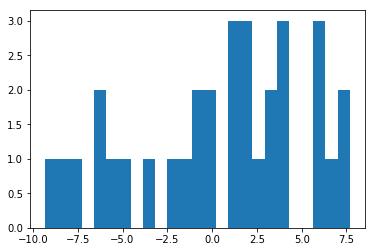

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



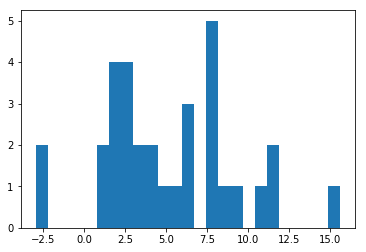

0.0414018630981
Training epoch 1000
Iter: 1000
D loss: 79.31
G_loss: 412.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.961161


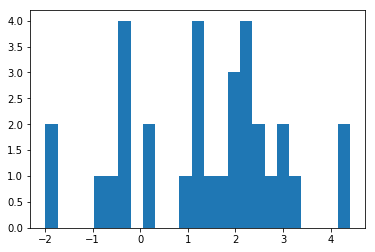

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



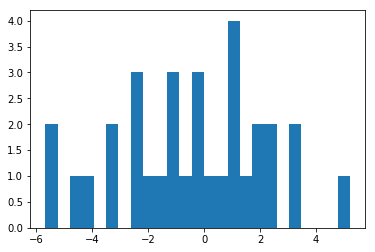

0.039078950882
Training epoch 2000
Iter: 2000
D loss: 56.85
G_loss: 416.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.7725


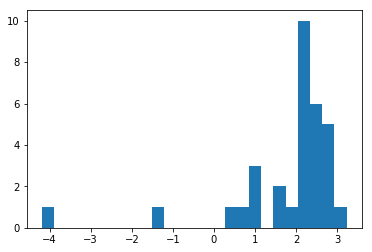

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



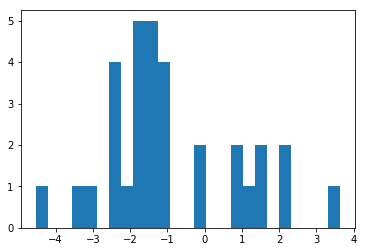

0.0386309623718
Training epoch 3000
Iter: 3000
D loss: 39.27
G_loss: 501.4
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.67418


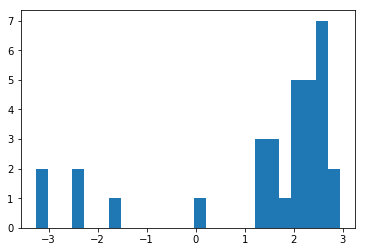

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



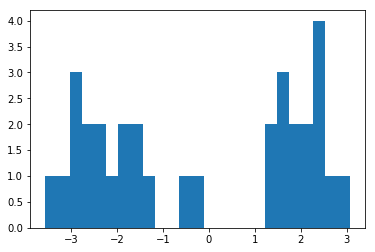

0.0394699573517
Training epoch 4000
Iter: 4000
D loss: 40.02
G_loss: 428.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.99161


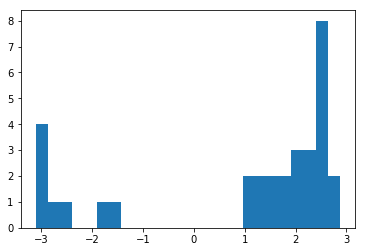

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



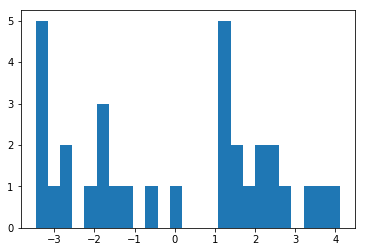

0.0383331775665
Training epoch 5000
Iter: 5000
D loss: 37.41
G_loss: 390.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.10145


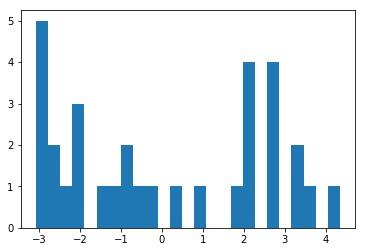

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



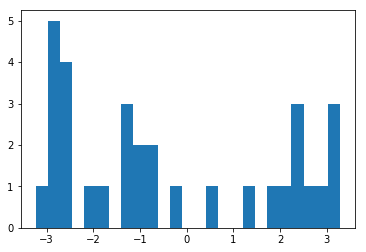

0.0385119915009
Training epoch 6000
Iter: 6000
D loss: 34.3
G_loss: 522.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.03182


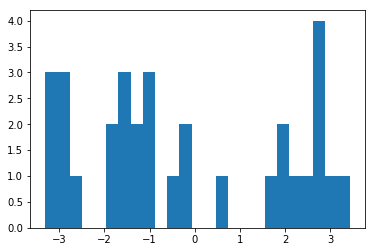

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



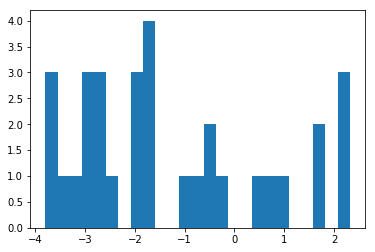

0.0400648117065
Training epoch 7000
Iter: 7000
D loss: 27.44
G_loss: 424.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.689853


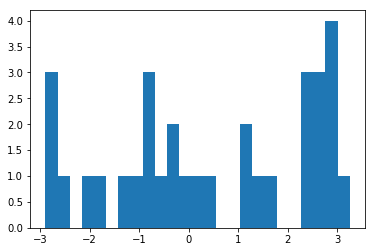

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



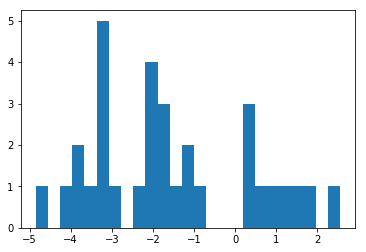

0.0482308864594
Training epoch 8000
Iter: 8000
D loss: 34.09
G_loss: 455.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.554189


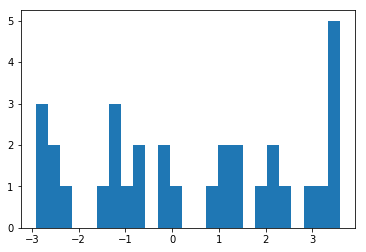

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



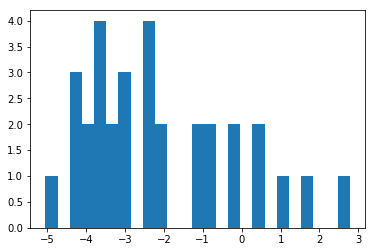

0.0398738384247
Training epoch 9000
Iter: 9000
D loss: 33.11
G_loss: 488.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.33986


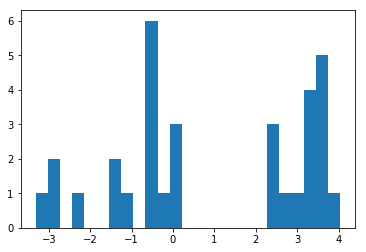

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



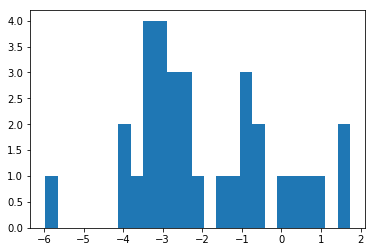

0.0455288887024
Training epoch 10000
Iter: 10000
D loss: 28.68
G_loss: 481.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.08175


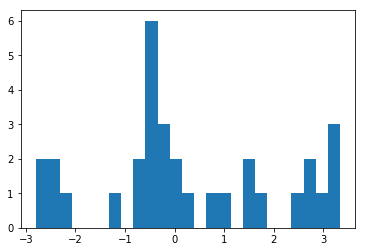

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



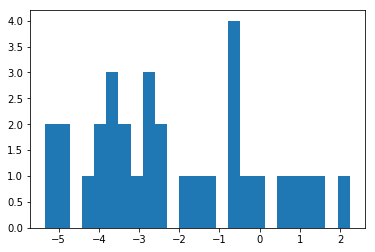

0.0411930084229
Training epoch 11000
Iter: 11000
D loss: 25.09
G_loss: 417.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.10809


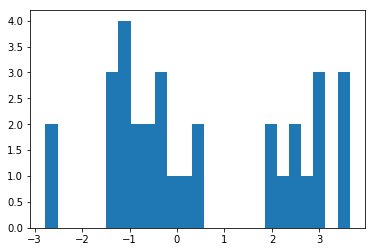

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



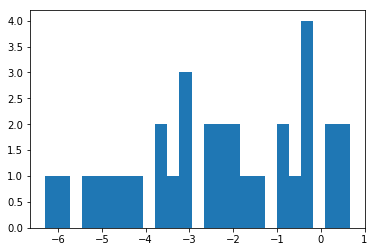

0.0387620925903
Training epoch 12000
Iter: 12000
D loss: 33.16
G_loss: 471.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.07731


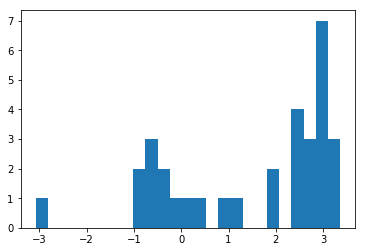

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



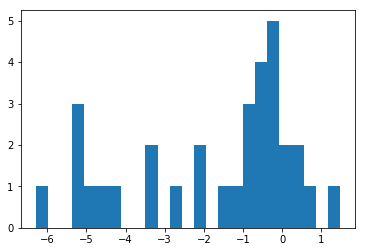

0.042240858078
Training epoch 13000
Iter: 13000
D loss: 28.04
G_loss: 449.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.975813


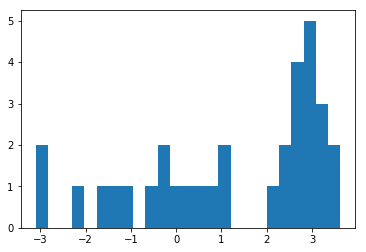

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



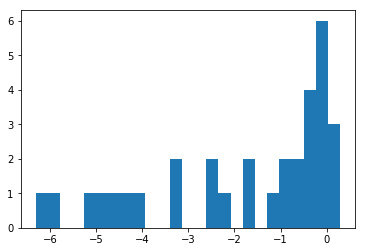

0.0449500083923
Training epoch 14000
Iter: 14000
D loss: 25.84
G_loss: 453.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.39114


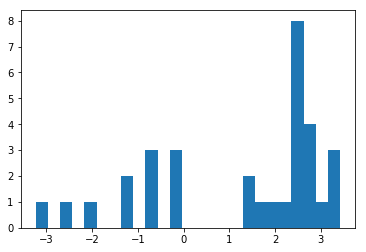

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



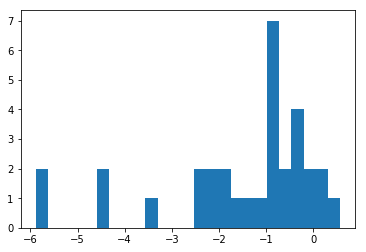

0.0395560264587
Training epoch 15000
Iter: 15000
D loss: 38.13
G_loss: 460.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.890358


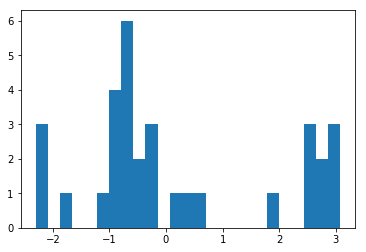

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



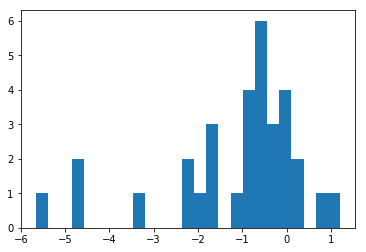

0.0475578308105
Training epoch 16000
Iter: 16000
D loss: 31.79
G_loss: 513.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.12556


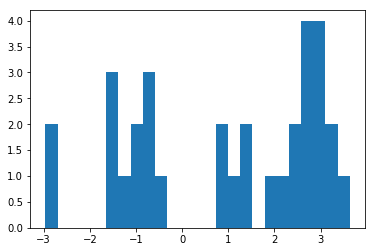

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



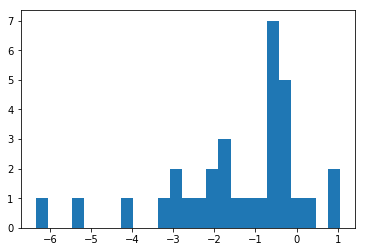

0.0396540164948
Training epoch 17000
Iter: 17000
D loss: 38.56
G_loss: 512.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
1.54136


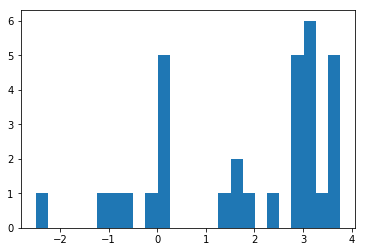

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



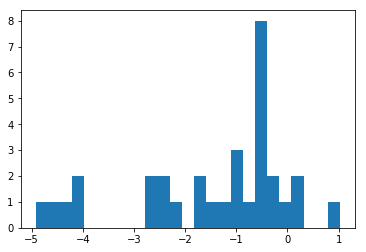

0.049309015274
Training epoch 18000
Iter: 18000
D loss: 39.76
G_loss: 444.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.6201


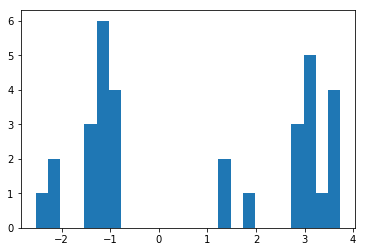

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



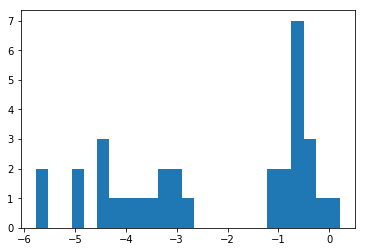

0.0393059253693
Training epoch 19000
Iter: 19000
D loss: 36.37
G_loss: 409.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.319298


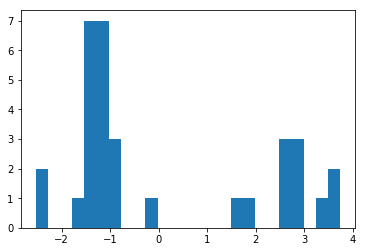

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



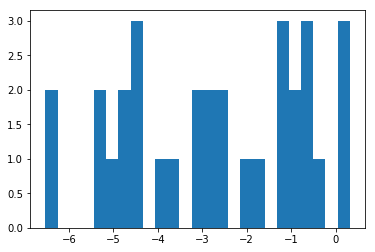

0.0638530254364
Training epoch 20000
Iter: 20000
D loss: 41.49
G_loss: 433.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.685496


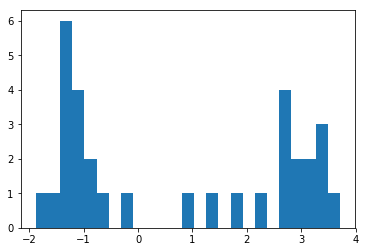

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



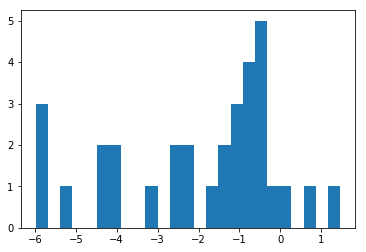

0.0473470687866
Training epoch 21000
Iter: 21000
D loss: 37.63
G_loss: 494.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.0701949


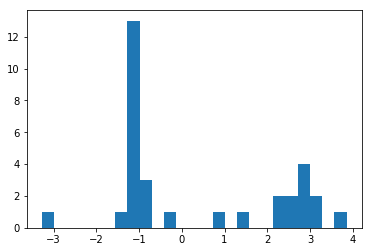

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



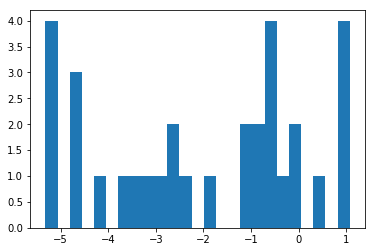

0.0395810604095
Training epoch 22000
Iter: 22000
D loss: 25.46
G_loss: 455.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.0896592


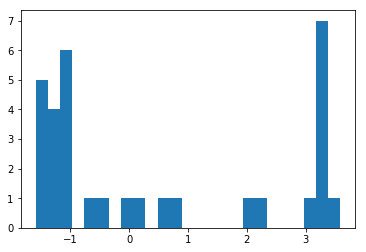

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



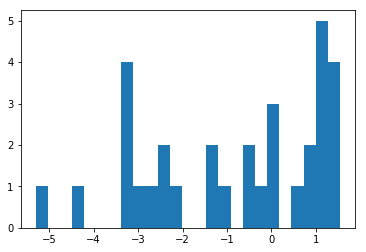

0.0410490036011
Training epoch 23000
Iter: 23000
D loss: 45.41
G_loss: 418.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.947869


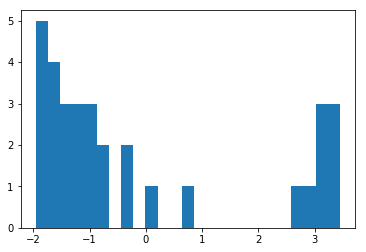

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



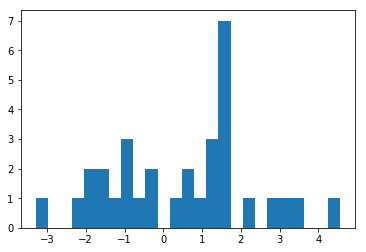

0.0386230945587
Training epoch 24000
Iter: 24000
D loss: 56.22
G_loss: 444.4
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.980091


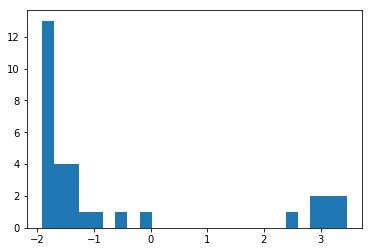

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



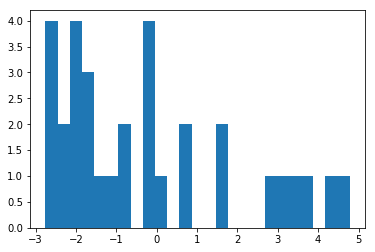

0.0438480377197
Training epoch 25000
Iter: 25000
D loss: 49.21
G_loss: 508.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-0.851486


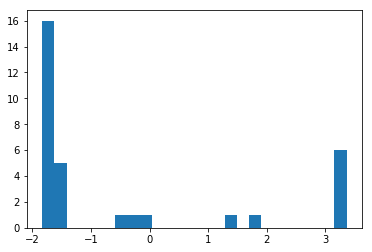

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



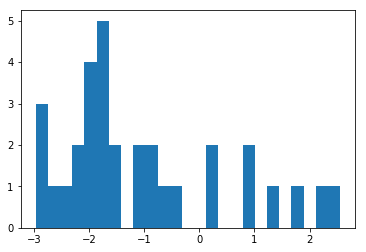

0.0554959774017
Training epoch 26000
Iter: 26000
D loss: 54.55
G_loss: 470.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.50325


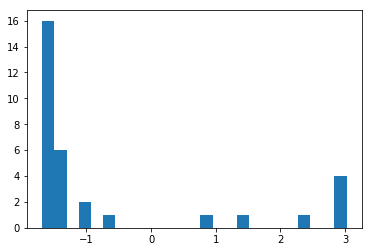

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



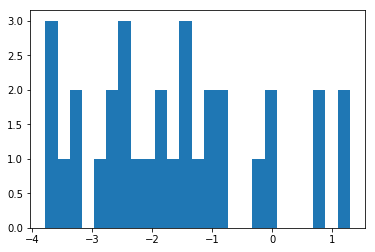

0.0588347911835
Training epoch 27000
Iter: 27000
D loss: 38.24
G_loss: 509.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
0.386497


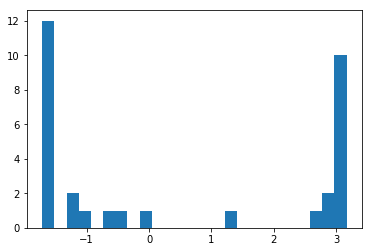

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



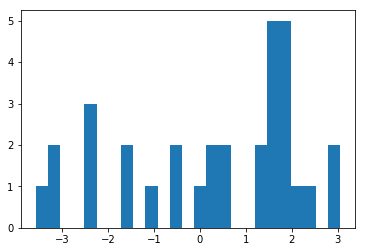

0.0420100688934
Training epoch 28000
Iter: 28000
D loss: 35.24
G_loss: 396.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.89364


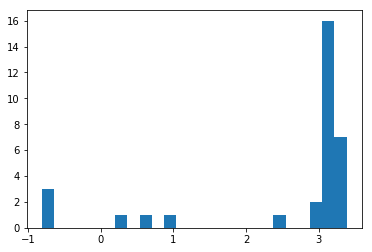

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



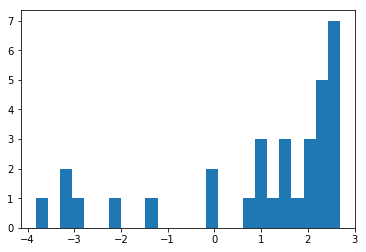

0.0407059192657
Training epoch 29000
Iter: 29000
D loss: 39.92
G_loss: 424.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.19341


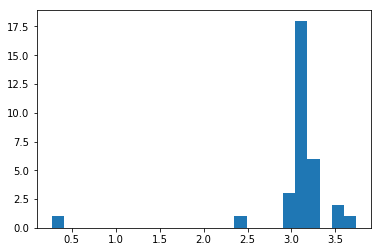

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



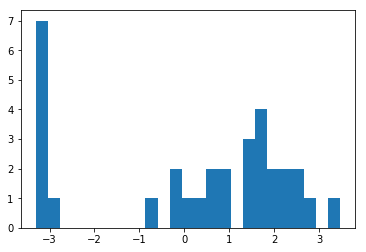

0.039381980896
Training epoch 30000
Iter: 30000
D loss: 42.6
G_loss: 451.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.3572


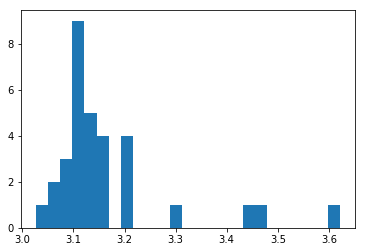

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



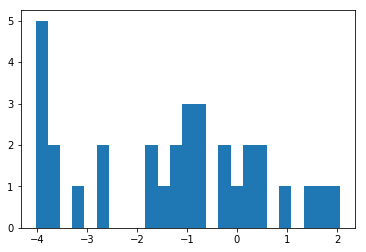

0.0385148525238
Training epoch 31000
Iter: 31000
D loss: 34.07
G_loss: 423.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.14981


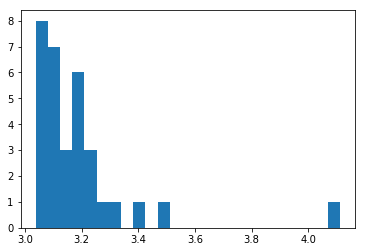

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



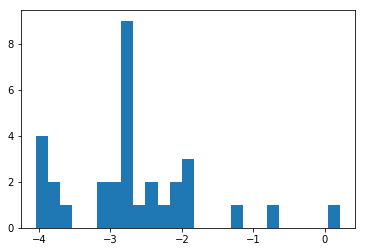

0.0389831066132
Training epoch 32000
Iter: 32000
D loss: 31.69
G_loss: 485.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.08571


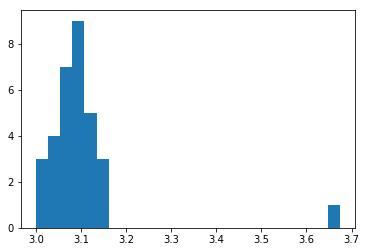

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



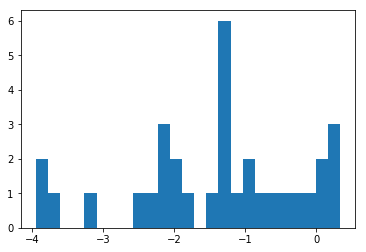

0.0479900836945
Training epoch 33000
Iter: 33000
D loss: 41.4
G_loss: 410.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.22078


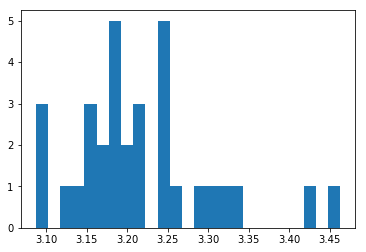

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



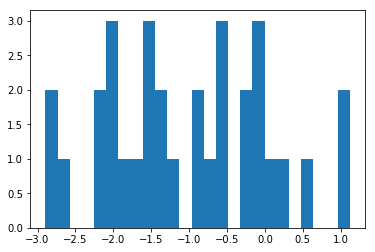

0.0407609939575
Training epoch 34000
Iter: 34000
D loss: 29.64
G_loss: 493.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.39497


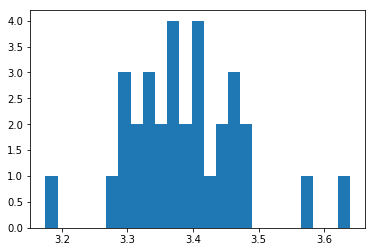

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



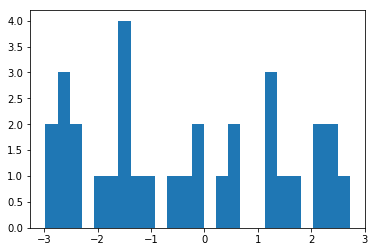

0.0496101379395
Training epoch 35000
Iter: 35000
D loss: 29.05
G_loss: 412.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.04546


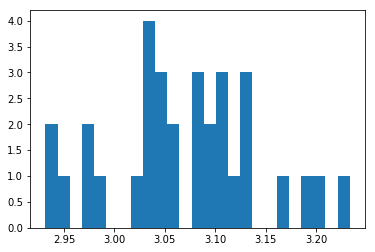

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



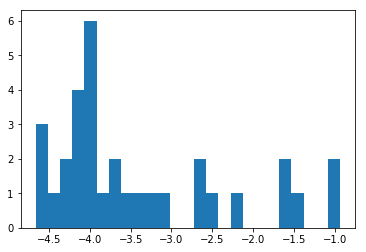

0.0397350788116
Training epoch 36000
Iter: 36000
D loss: 26.95
G_loss: 433.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.14683


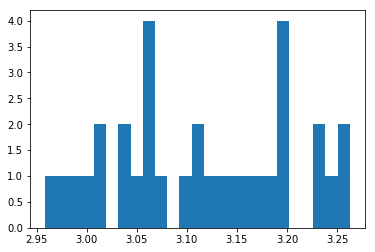

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



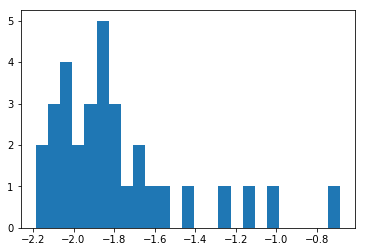

0.0418510437012
Training epoch 37000
Iter: 37000
D loss: 20.53
G_loss: 477.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.24569


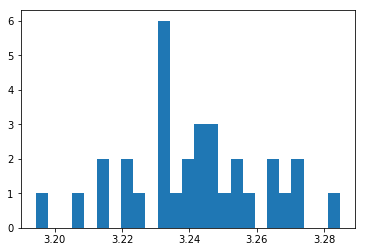

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



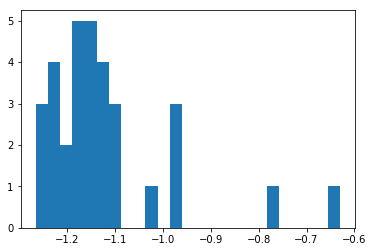

0.0386190414429
Training epoch 38000
Iter: 38000
D loss: 17.21
G_loss: 494.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.18578


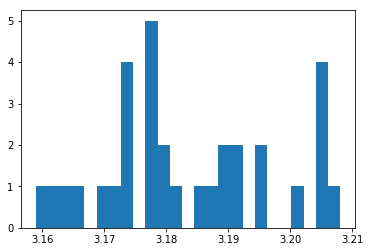

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



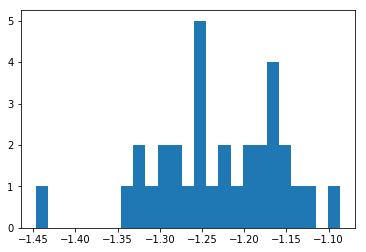

0.0372970104218
Training epoch 39000
Iter: 39000
D loss: 13.3
G_loss: 499.5
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.8302


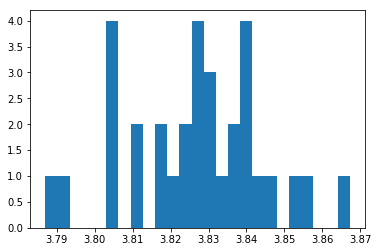

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



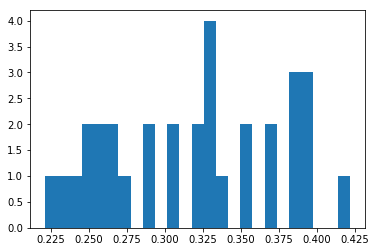

0.047278881073
Training epoch 40000
Iter: 40000
D loss: 11.26
G_loss: 523.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.78915


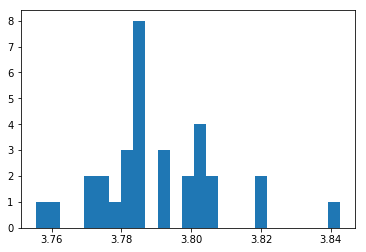

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



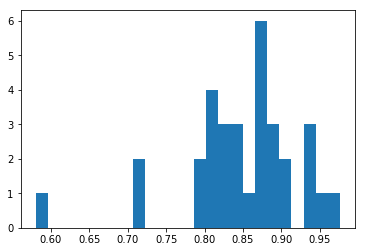

0.0412428379059
Training epoch 41000
Iter: 41000
D loss: 12.48
G_loss: 484.1
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.64369


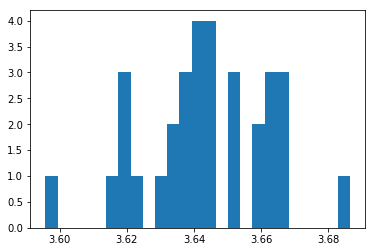

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



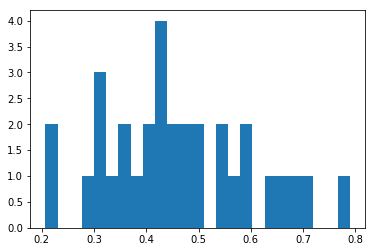

0.041424036026
Training epoch 42000
Iter: 42000
D loss: 16.21
G_loss: 453.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.37845


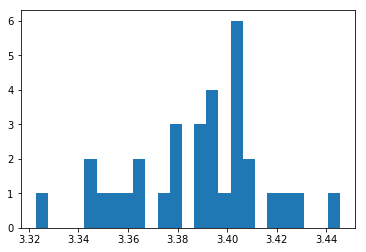

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



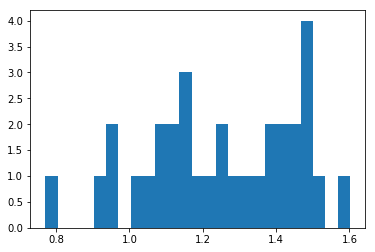

0.0447158813477
Training epoch 43000
Iter: 43000
D loss: 21.09
G_loss: 488.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.29136


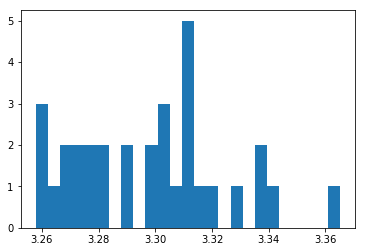

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



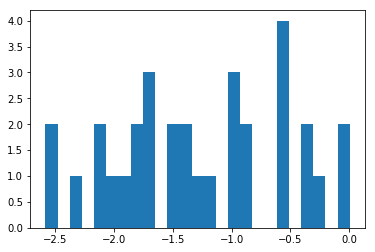

0.0710680484772
Training epoch 44000
Iter: 44000
D loss: 14.14
G_loss: 484.7
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.48531


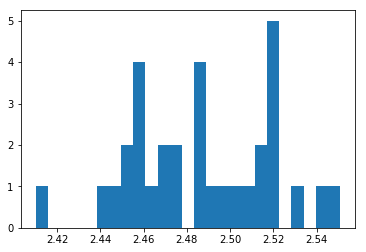

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



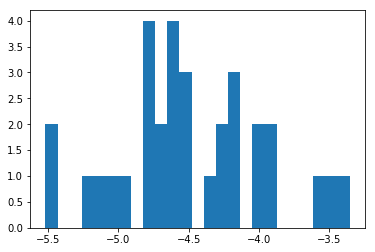

0.0400800704956
Training epoch 45000
Iter: 45000
D loss: 10.71
G_loss: 464.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.62931


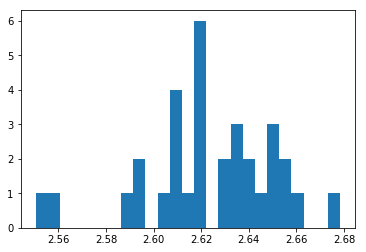

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



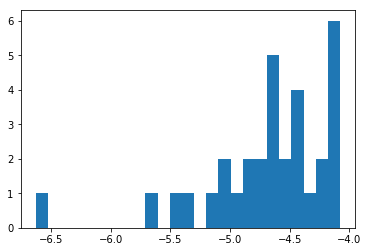

0.0486690998077
Training epoch 46000
Iter: 46000
D loss: 10.01
G_loss: 488.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.73721


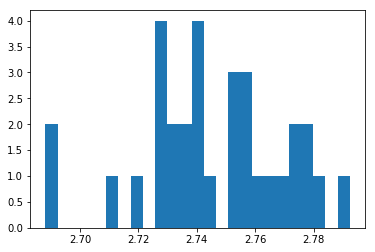

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



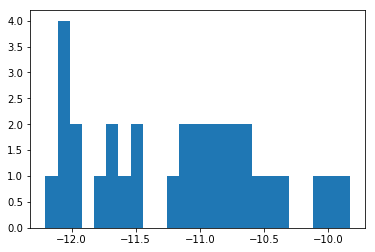

0.0406711101532
Training epoch 47000
Iter: 47000
D loss: 8.629
G_loss: 469.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.63958


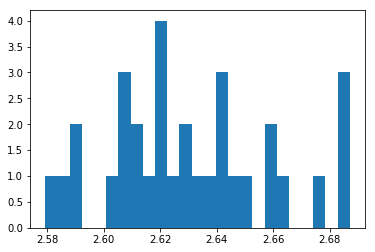

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



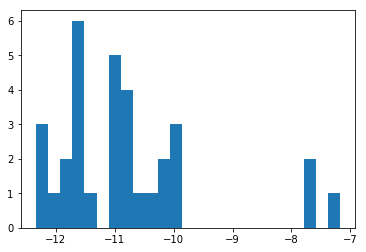

0.0407001972198
Training epoch 48000
Iter: 48000
D loss: 21.56
G_loss: 495.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.61457


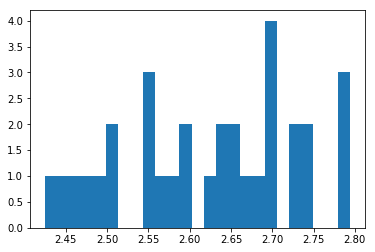

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



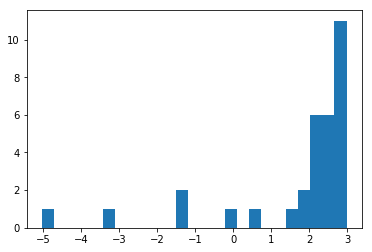

0.0395050048828
Training epoch 49000
Iter: 49000
D loss: 11.08
G_loss: 498.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.07381


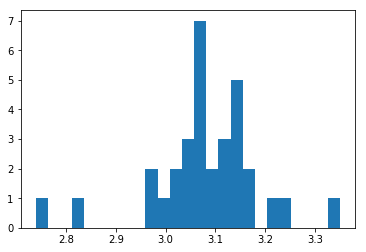

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



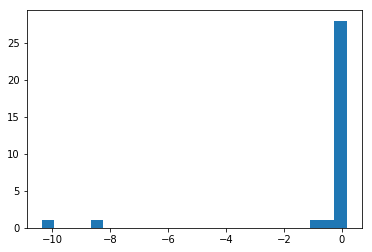

0.0417008399963
Training epoch 50000
Iter: 50000
D loss: 13.13
G_loss: 443.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.97036


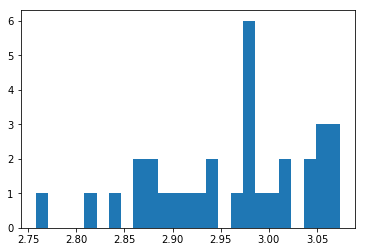

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



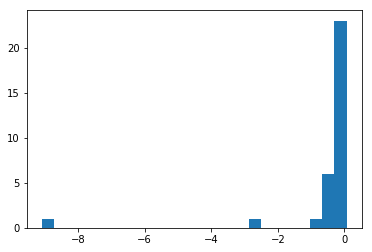

0.0610220432281
Training epoch 51000
Iter: 51000
D loss: 10.81
G_loss: 500.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.83321


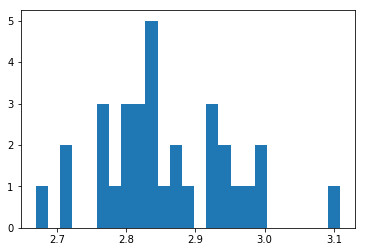

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



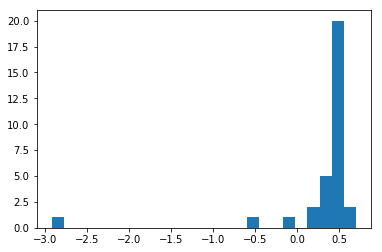

0.03946185112
Training epoch 52000
Iter: 52000
D loss: 11.67
G_loss: 486.8
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.56722


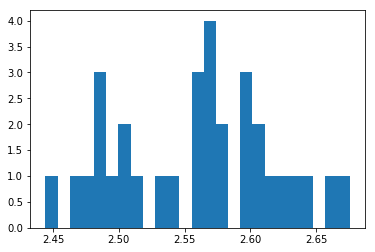

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



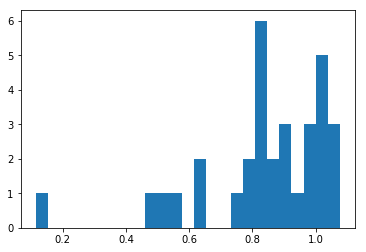

0.0401091575623
Training epoch 53000
Iter: 53000
D loss: 14.38
G_loss: 483.3
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.74393


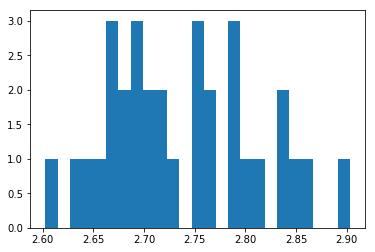

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



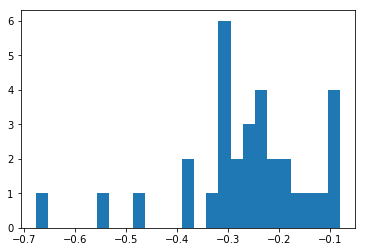

0.042445898056
Training epoch 54000
Iter: 54000
D loss: 12.67
G_loss: 531.2
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
3.22969


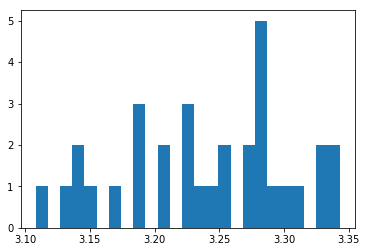

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



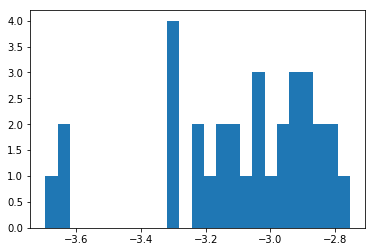

0.0415840148926
Training epoch 55000
Iter: 55000
D loss: 9.076
G_loss: 480.9
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.99816


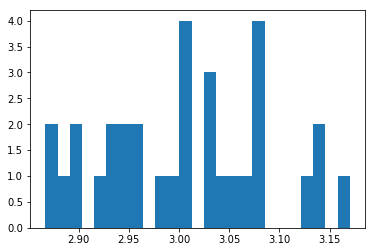

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



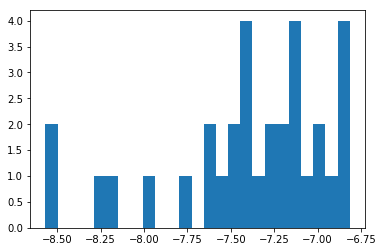

0.0400221347809
Training epoch 56000
Iter: 56000
D loss: 19.84
G_loss: 466.0
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
2.57393


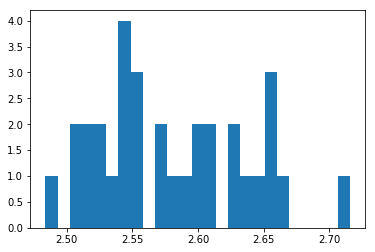

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



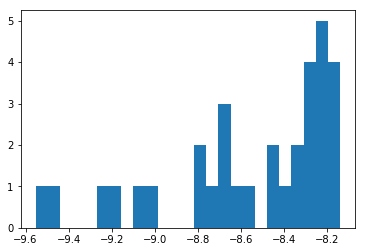

0.0408918857574
Training epoch 57000
Iter: 57000
D loss: 13.72
G_loss: 491.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.25096


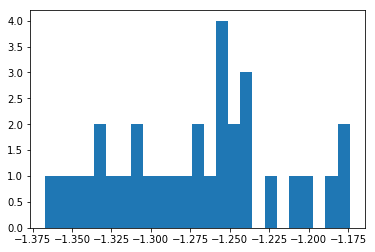

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



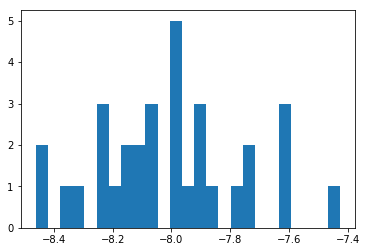

0.0775928497314
Training epoch 58000
Iter: 58000
D loss: 14.13
G_loss: 493.6
4wks:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
-0.912921
-1.27497


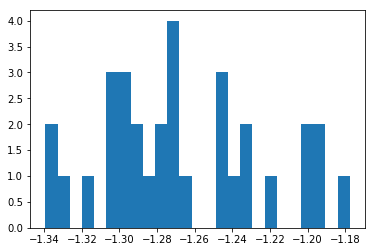

/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
Butane:



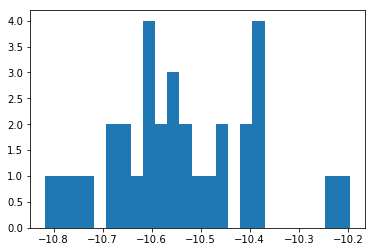

KeyboardInterrupt: 

In [2122]:
every = 1000
#train_dataset = features[:1]*32
train_dataset = features[:96*2]
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        

        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run(
            [D_solver, D_loss] + d_ops, feed_dict=feed_dict)[0:2]
        
        _, G_loss_curr = sess.run([G_solver, G_loss] + g_ops, feed_dict=feed_dict)[0:2]
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        
        print("4wks:\n")
        
        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))

        print(np.mean(sess.run(dihed_tensor, feed_dict=feed_dict)[:, 0]))
        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        print("Butane:\n")
        feed_dict = construct_feed_dict(features[len(features)-32:], 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



In [ ]:
features[4]

In [ ]:
every = 1000
#train_dataset = features[:96]
train_dataset = features[:1]*S
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1.)
        
        print("4wks:\n")
        
        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))

        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        print("Butane:\n")
        feed_dict = construct_feed_dict(features[len(features)-32:], 0, S, shuffle_inds=False, keep_prob_val=1.)
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



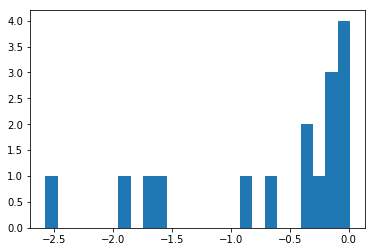

In [321]:
S=16
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)

plt.hist(np.squeeze(sess.run(dihed, feed_dict=feed_dict)), bins=25)
plt.show()

In [216]:
features[1]

('/home/evan/Documents/deep_docking/datasets/v2015/2ohk/2ohk_ligand.mol2',
 array([[-1.2731,  0.9987, -2.2001],
        [-0.5031,  1.0397, -1.0801],
        [-0.0411,  2.2447, -0.6841],
        [ 0.7269,  2.2857,  0.4109],
        [ 1.0309,  1.1747,  1.1729],
        [ 0.5309, -0.0663,  0.8089],
        [ 0.7909, -1.2213,  1.5379],
        [ 0.2719, -2.4343,  1.1299],
        [-0.4991, -2.5073, -0.0101],
        [-0.7681, -1.3733, -0.7401],
        [-0.2671, -0.1413, -0.3461],
        [ 0.    ,  0.    ,  0.    ]]),
 array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=uint8),
 array([[ 0.]]),
 array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0

In [ ]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [ ]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = tf.nn.tanh(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

In [ ]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [ ]:
c.SetAtomPosition(0, [0., 0., 0.])

In [ ]:
np.where(features[2][1][:,:,:,:-1] == 1)

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [ ]:
features[1][0]

In [ ]:
mol = Chem.MolFromMol2File(features[1][0])
mol.GetNumAtoms()

In [ ]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

In [ ]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)